In [1]:
import numpy as np
import os
import cv2
import h5py

from scipy.signal import medfilt2d
from scipy.ndimage import convolve,correlate

import matplotlib.pyplot as plt

In [2]:
#Local grayscale standardization
def localstandard(im,w1,w2,sigma1,sigma2):
    #Centers grayscales with Gaussian weighted mean
    #Gaussian kernels
    kernel1 = Gauss2D(w1,sigma1)
    kernel2 = Gauss2D(w2,sigma2)		
    #Blurring
    blurred1 = convolve(im,kernel1)
    #Centering grayscale values
    centered = im-blurred1
    #Standardization
    std = (convolve(centered**2,kernel2))**0.5
    new_im = centered/(std+1e-09)
    return new_im

#Bilinear interpolation
def imbilinear(im,col,x,row,y):
    #Takes bilinear interpotalion from image
    #Starts from coordinates [y,x], ends at row,col
    x1 = int(np.floor(x))
    x2 = int(np.ceil(x))
    y1 = int(np.floor(y))
    y2 = int(np.ceil(y))

    Q11 = im[y2:y2+row,x1:x1+col]
    Q21 = im[y2:y2+row,x2:x2+col]
    Q12 = im[y1:y1+row,x1:x1+col]
    Q22 = im[y1:y1+row,x2:x2+col]

    R1 = ((x2-x)/(x2-x1))*Q11+((x-x1)/(x2-x1))*Q21
    R2 = ((x2-x)/(x2-x1))*Q12+((x-x1)/(x2-x1))*Q22
    P = ((y-y1)/(y2-y1))*R1+((y2-y)/(y2-y1))*R2
    return P

#Gaussian kernel
def Gauss2D(w,sigma):
    #Generates 2d gaussian kernel
    kernel = np.zeros((w,w))
    #Constant for centering
    r = (w-1)/2
    for ii in range(w):
        for jj in range(w):
            x = -((ii-r)**2+(jj-r)**2)/(2*sigma**2)
            kernel[ii,jj] = np.exp(x)
    #Normalizing the kernel
    kernel = 1/np.sum(kernel)*kernel
    return kernel

#MRELBP
def MRELBP(im,N,R,r,w_c,w_r):
    #Takes Median Robust Extended Local Binary Pattern from image im
    #Uses N neighbours from radii R and r, R must be larger than r
    #Median filter uses kernel sizes w_c for center pixels, w_r[0] for larger radius and w_r[1]
    #for smaller radius	
    #Grayscale values are centered at their mean and scales with global standad deviation

    #Mean grayscale value and std
    muI = im.mean()
    stdI = im.std()

    #Centering and scaling with std
    I = (im-muI)/stdI

    #Median filtering
    Ic = medfilt2d(I,w_c)
    #Center pixels
    d = round(R+w_r[0]//2)
    Ic = Ic[d:-d,d:-d]
    #Subtracting the mean pixel value from center pixels
    Ic = Ic-Ic.mean()
    #Bining center pixels
    Chist = np.zeros((1,2))
    Chist[0,0] = np.sum(Ic>=0)
    Chist[0,1] = np.sum(Ic<0)

    #Median filtered images for large and small radius
    IL = medfilt2d(I,w_r[0])
    #d1 = round((w_r[0]-1)/2)
    #IL = IL[d1:-d1,d1:-d1]
    IS = medfilt2d(I,w_r[1])
    #d2 = round((w_r[1]-1)/2)
    #IS = IS[d2:-d2,d2:-d2]

    #Neighbours
    pi = np.pi
    #Empty arrays for the neighbours
    row,col = np.shape(Ic)
    NL = np.zeros((row,col,N))
    NS = np.zeros((row,col,N))
    for k in range(0,N):
        #Angle to the neighbour
        theta = 0-k*(2*pi/N)
        #Large neighbourhood
        x = d+R*np.cos(theta)
        y = d+R*np.sin(theta)
        if abs(x-round(x)) < 1e-6 and abs(y-round(y)) < 1e-6:
            x = int(round(x))
            y = int(round(y))
            P = IL[y:y+row,x:x+col]
        else:
            P = imbilinear(IL,col,x,row,y)
        NL[:,:,k] = P
        #Small neighbourhood
        x = d+r*np.cos(theta)
        y = d+r*np.sin(theta)
        if abs(x-round(x)) < 1e-6 and abs(y-round(y)) < 1e-6:
            x = int(round(x))
            y = int(round(y))
            P = IS[y:y+row,x:x+col]
        else:
            P = imbilinear(IS,col,x,row,y)
        NS[:,:,k] = P
    #Thresholding

    #Thresholding radial neighbourhood
    NR = NL-NS

    #Subtraction of means
    #Large neighbourhood
    NLmu = NL.mean(axis=2)
    #Small neighbouhood
    NSmu = NS.mean(axis=2)

    for k in range(N):
        NL[:,:,k] = NL[:,:,k]-NLmu
        NS[:,:,k] = NS[:,:,k]-NSmu

    #Converting to binary images and taking the lbp values
    #Initialization of arrays
    lbpIL = np.zeros((row,col))
    lbpIS = np.zeros((row,col))
    lbpIR = np.zeros((row,col))

    for k in range(N):
        print(2**k)
        lbpIL += (NL[:,:,k]>=0)*2**k
        lbpIS += (NS[:,:,k]>=0)*2**k
        lbpIR += (NR[:,:,k]>=0)*2**k
    plt.imshow(lbpIL,cmap='jet')
    plt.show()
    print(lbpIL.shape)
    print([lbpIL.min(),lbpIL.max()])
    #Binning
    Lhist = np.zeros((1,2**N))
    Shist = np.zeros((1,2**N))
    Rhist = np.zeros((1,2**N))
    for k in range(2**N):
        Lhist[0,k] = np.sum(lbpIL==k)
        Shist[0,k] = np.sum(lbpIS==k)
        Rhist[0,k] = np.sum(lbpIR==k)

    #Chist = 1/np.linalg.norm(Chist)*Chist
    #Lhist = 1/np.linalg.norm(Lhist)*Lhist
    #Shist = 1/np.linalg.norm(Shist)*Shist
    #Rhist = 1/np.linalg.norm(Rhist)*Rhist
    hist = np.concatenate((Chist,Lhist,Shist,Rhist),1)
    
    return hist,(NS>=0)*1.0, I


In [3]:
def make_2d_gauss(ks,sigma):
    #Mean indices
    c = ks//2
    
    #Exponents
    x = (np.linspace(0,ks-1,ks)-c)**2
    y = (np.linspace(0,ks-1,ks)-c)**2
    
    #Evaluate exponential functions
    ex = np.exp(-0.5*x/sigma**2)
    ey = np.exp(-0.5*y/sigma**2)
    
    #Iterate over kernel size
    kernel = np.zeros((ks,ks))
    for k in range(ks):
        kernel[k,:] = ey[k]*ex
    
    #Normalize so kernel sums to 1
    kernel /= kernel.sum()
    
    return kernel

def local_normalize(image,ks1,sigma1,ks2,sigma2 ):
    #Generate gaussian kernel
    kernel1 = make_2d_gauss(ks1,sigma1)
    kernel2 = make_2d_gauss(ks2,sigma2)
    
    mu = correlate(image,kernel1)
    
    centered = image-mu
    
    sd = correlate(centered**2,kernel2)**0.5
    
    return centered/(sd+1e-9)

#Mapping
def getmapping(N):
    #Defines rotation invariant uniform mapping for lbp of N neighbours	
    newMax = N + 2
    table = np.zeros((1,2**N))
    for k in range(2**N):
        #Binary representation of bin number
        binrep = np.binary_repr(k,N)
        #Convert string to list of digits
        i_bin = np.zeros((1,len(binrep)))
    for ii in range(len(binrep)):
        i_bin[0,ii] = int(float(binrep[ii]))
        #Rotation
        j_bin = np.roll(i_bin,-1)
        #uniformity
        numt = np.sum(i_bin!=j_bin)
        #Binning
        if numt <= 2:
            b = np.binary_repr(k,N)
            c=0
            for ii in range(len(b)):
                c = c+int(float(b[ii]))
            table[0,k] = c
        else:
            table[0,k] = N+1
    #num = newMax
    return table

#Apply mapping to lbp
def maplbp(inbin,mapping):
    #Applies mapping to lbp bin
    #Number of bins in output
    N = int(np.max(mapping))
    #Empty array
    outbin = np.zeros((1,N+1))
    for k in range(N+1):
        #RIU indices
        M = mapping==k
        #Extract indices from original bin to new bin
        outbin[0,k] = np.sum(M*inbin)
    return outbin

def weight_matrix_bilin(r,theta,val = -1):
    #Center of the matrix
    x = r+1
    y = r+1
    
    #Matrix
    s = int(2*(r+1)+1)
    kernel = np.zeros((s,s))
    
    #Accurate location
    _y = y+np.sin(theta)*r
    _x = x+np.cos(theta)*r
    #Rounded locations
    x1 = np.floor(_x)
    x2 = np.ceil(_x)
    y1 = np.floor(_y)
    y2 = np.ceil(_y)
    
    #Interpolation weights
    wx2 = (_x-x1)
    if wx2 == 0:
        wx2 = 1
    wx1 = (x2-_x)
    if wx1 == 0:
        wx1 = 1
    wy2 = (_y-y1)
    if wy2 == 0:
        wy2 = 1
    wy1 = (y2-_y)
    if wy1 == 0:
        wy1 = 1
    
    w11 = wx1*wy1
    w12 = wx2*wy1
    w21 = wx1*wy2
    w22 = wx2*wy2


    kernel[int(y1),int(x1)] = w11
    kernel[int(y1),int(x2)] = w12
    kernel[int(y2),int(x1)] = w21
    kernel[int(y2),int(x2)] = w22
    
    #Set center value
    kernel[x,y] += val
    
    #plt.imshow(kernel,cmap='gray')
    #plt.show()
    
    return kernel

def Conv_MRELBP(image,N,R,r,wR,wr,wc):
    #Whiten the image
    imu = image.mean()
    istd = image.std()
    im = (image-imu)/istd
    #Get image dimensions
    h,w = im.shape[:2]
    #Make kernels
    kR = []
    kr = []
    dtheta = np.pi*2/N
    for k in range(0,N):
        _kernel = weight_matrix_bilin(R,-k*dtheta,val=0)
        kR.append(_kernel)
        
        _kernel = weight_matrix_bilin(r,-k*dtheta,val=0)
        kr.append(_kernel)
        
    #Make median filtered images
    imc = medfilt2d(im.copy(),wc)
    imR = medfilt2d(im.copy(),wR)
    imr = medfilt2d(im.copy(),wr)
        
    #Get LBP images
    neighbR = np.zeros((h,w,N))
    neighbr = np.zeros((h,w,N))
    for k in range(N):
        _neighb = correlate(imR,kR[k])
        neighbR[:,:,k] = _neighb
        _neighb = correlate(imr,kr[k])
        neighbr[:,:,k] = _neighb
    
    
    #Crop valid convolution region
    d = R+wR//2
    h -=2*d
    w -=2*d
    
    
    neighbR = neighbR[d:-d,d:-d,:]
    neighbr = neighbr[d:-d,d:-d,:]
    imc = imc[d:-d,d:-d]
    
    #Subtraction
    _muR = neighbR.mean(2).reshape(h,w,1)
    for k in range(N):
        try:
            muR = np.concatenate((muR,_muR),2)
        except NameError:
            muR = _muR
            
    _mur = neighbr.mean(2).reshape(h,w,1)
    for k in range(N):
        try:
            mur = np.concatenate((mur,_mur),2)
        except NameError:
            mur = _mur
            
    diffc = (imc-imc.mean())>=0
    diffR = (neighbR-muR)>=0
    diffr = (neighbr-mur)>=0
    diffR_r = (neighbR-neighbr)>=0
    
    #Compute lbp images
    lbpc = diffc
    lbpR = np.zeros((h,w))
    lbpr = np.zeros((h,w))
    lbpR_r = np.zeros((h,w))
    for k in range(N):
        print(2**k)
        lbpR += diffR[:,:,k]*(2**k)
        lbpr += diffr[:,:,k]*(2**k)
        lbpR_r += diffR_r[:,:,k]*(2**k)
    plt.imshow(lbpR,cmap='jet')
    plt.show()
    print(lbpR.shape)
    print([lbpR.min(),lbpR.max()])
    #Get LBP histograms
    histc = np.zeros((1,2))
    histR = np.zeros((1,2**N))
    histr = np.zeros((1,2**N))
    histR_r = np.zeros((1,2**N))
    
    histc[0,0] = (lbpc==1).astype(np.float32).sum()
    histc[0,1] = (lbpc==0).astype(np.float32).sum()
    
    for k in range(2**N):
        histR[0,k] = (lbpR==k).astype(np.float32).sum()
        histr[0,k] = (lbpr==k).astype(np.float32).sum()
        histR_r[0,k] = (lbpR_r==k).astype(np.float32).sum()
    
    
    #Mapping
    #mapping = getmapping(N)
    #histR = maplbp(histR,mapping)
    #histr = maplbp(histr,mapping)
    #histR_r = maplbp(histR_r,mapping)
    
    #Append histograms
    hist = np.concatenate((histc,histR,histr,histR_r),1)
    
    return hist, diffr, im

1
2
4
8
16
32
64
128


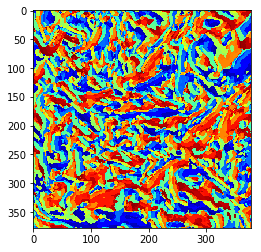

(378, 378)
[1.0, 254.0]
1
2
4
8
16
32
64
128


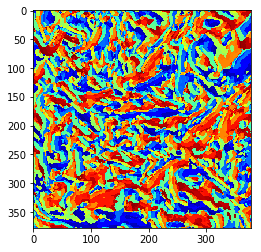

(378, 378)
[1.0, 254.0]


In [4]:
path = './cartvoi_surf_new/13_R3L__surf.h5'
h5 = h5py.File(path,'r')
im = h5['sum'][:]
h5.close()

lbp1,diffR1,i1 = MRELBP(im,8,9,3,5,(5,5))
lbp2,diffR2,i2 = Conv_MRELBP(im,8,9,3,5,5,5)

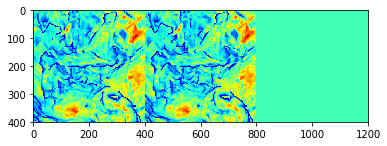

In [5]:
cntrd = np.concatenate((i1,i2,np.abs(i1-i2)),1)
plt.imshow(cntrd,cmap='jet')
plt.show()

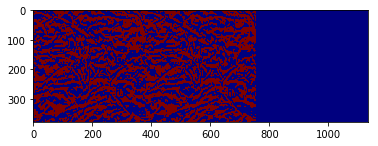

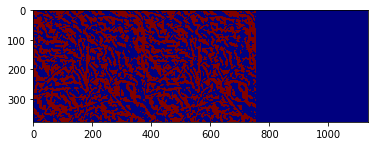

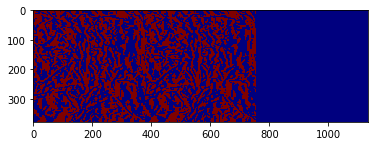

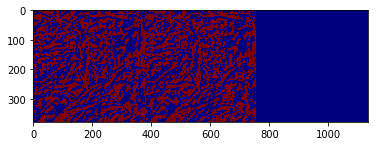

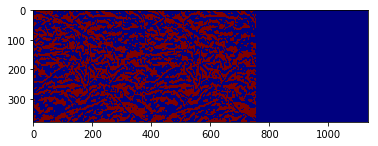

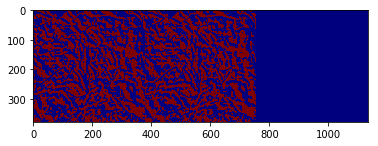

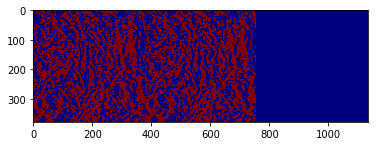

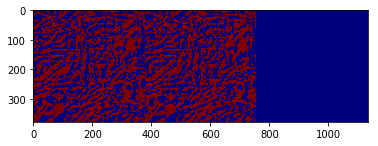

In [6]:
for im1,im2 in zip(diffR1.swapaxes(0,2),diffR2.swapaxes(0,2)):
    I = np.concatenate((im1,im2,(im1-im2)),1)
    plt.imshow(I,cmap='jet')
    plt.show()

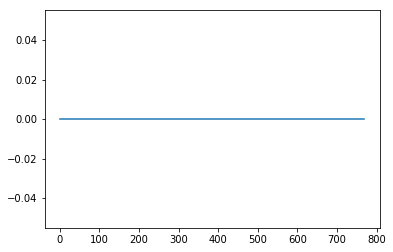

In [8]:
l1 = lbp1
l2 = lbp2
#plt.plot(l1[0][2:])
plt.plot(l1[0][:]-l2[0][:])
#plt.xlim(0,2)
#plt.ylim(0,400*40)
plt.show()